<img src="https://assets.ensam.eu/logo/fr/logo-trans-322x84.png" style="width:256px" > <img src="https://upload.wikimedia.org/wikipedia/commons/1/12/Cc-by-nc-sa_icon.svg" width=192 align=right>

**Author :** Jean-Christophe Loiseau

**Email :** [jean-christophe.loiseau@ensam.eu](mailto:jean-christophe.loiseau@ensam.eu)

**Date :** January 2025

---

In [1]:
import numpy as np
import scipy as sp
from scipy import ndimage, sparse
import matplotlib.pyplot as plt

$$
\DeclareMathOperator*{\minimize}{minimize~}
\DeclareMathOperator*{\maximize}{maximize~}
\DeclareMathOperator*{\argmin}{argmin~}
\DeclareMathOperator*{\argmax}{argmax~}
\DeclareMathOperator*{\subto}{subject~to~}
$$

# **Convex optimization: the Alternating Direction Method of Multipliers (ADMM)**

## Introduction

Our objective in this notebook is to implement a simple yet fairly efficient convex solver.
More importantly, the algorithm we will focus on also benefits from excellent robustness properties and is a first step toward two other goals, namely:
- **Arbitrary-scale optimization**
    - Applications in *Machine Learning* and *Statistics* with huge datasets.
    - Dynamic optimization on large-scale networks.
- **Decentralized optimization**
    - Devices/processors/agents coordinate to solve a large-scale problem by passing only relatively small messages.
 
The approach we'll work with is known as the *Alternating Direction Method of Multipliers* (ADMM) and has been around since the mid 1970's, simulateneously proposed by [Glowinski & Marroco](http://archive.numdam.org/article/M2AN_1975__9_2_41_0.pdf) (1975) and [Gabay & Mercier](https://www.sciencedirect.com/science/article/pii/0898122176900031?via%3Dihub) (1976).
It however gained a surge of interest in the past two decade with the spread of large-scale/decentralized optimization problems.

The problems tackled by ADMM have the following standard form

$$
\begin{aligned}
    \minimize_{\mathbf{x}, \mathbf{z}} & \quad f(\mathbf{x}) + g(\mathbf{z}) \\
    \subto & \quad \mathbf{Ax} + \mathbf{Bz} = \mathbf{c},
\end{aligned}
$$

i.e. an equality-constrained optimization problem with $f : \mathbb{R}^{n_x} \to \mathbb{R}$ and $g : \mathbb{R}^{n_z} \to \mathbb{R}$ two convex functions.
This problem is thus a convex program with two sets of variables and a separable objective.
Before presenting the ADMM algorithm, we will however make two small detours providing some historical perspectives as well as motivating the rationale behind this method.

### **Dual problems, dual ascent, and dual decomposition**

Let us consider the following equality-constrained convex program

$$
    \begin{aligned}
        \minimize_{\mathbf{x}} & \quad f(\mathbf{x}) \\
        \subto & \quad \mathbf{Ax} = \mathbf{b}.
    \end{aligned}
$$

Its *Lagrangian* is given by

$$
    L(\mathbf{x}, \mathbf{v}) = f(\mathbf{x}) + \mathbf{v}^T \left( \mathbf{Ax} - \mathbf{b} \right).
$$

Associated with program and its Lagrangian are the *dual function* and the *dual problem*.
The dual function is given by

$$
    g(\mathbf{v}) = \inf_{\mathbf{x}} L(\mathbf{x}, \mathbf{v}),
$$

and the corresponding *dual problem* reads

$$
    \maximize_{\mathbf{v}} \quad g(\mathbf{v}).
$$

Note that if a maximizer $\mathbf{v}_{\star}$ of this dual problem is known, the solution of the original primal problem can be recovered as

$$
    \mathbf{x}_{\star} = \argmin_{\mathbf{x}} L(\mathbf{x}, \mathbf{v}_{\star}).
$$

But how to solve for the dual maximizer?

#### The dual ascent method

The simplest approach is to use a gradient-based algorithm.
Since we are trying to *maximize* the function $g(\mathbf{v})$, we will use a *gradient ascent* method rather than the traditional *gradient descent* one used for minimization problems.
The update rule for this acent method reads

$$
    \mathbf{v}_{t+1} = \mathbf{v}_t + \alpha_t \nabla g (\mathbf{v}_t).
$$

Note however that this update rule implicitly depends on the variable $\mathbf{x}$ since

$$
    \nabla g(\mathbf{v}) \equiv \mathbf{A} \hat{\mathbf{x}} - \mathbf{b}
$$

where $\displaystyle \hat{\mathbf{x}} = \argmin_{\mathbf{x}} L(\mathbf{x}, \mathbf{v}_t)$.
Hence, the dual ascent method consists of two steps:

$$
\begin{aligned}
    \mathbf{x}_{t+1} & = \argmin_{\mathbf{x}} L(\mathbf{x}, \mathbf{v}_t) \quad & \text{\color{gray}{// $\mathbf{x}$-minimization}} \\
    \mathbf{v}_{t+1} & = \mathbf{v}_t + \alpha_t \left( \mathbf{Ax}_{t+1} - \mathbf{b} \right) \quad & \text{\color{gray}{// dual update}}
\end{aligned}
$$

With an appropriate choice for the step size $\alpha_t$, we have that

$$
    g(\mathbf{v}_{t+1}) \geq g(\mathbf{v}_t).
$$

Moreover, if $f$ is *strictly convex* and under some assumptions on the step size $\alpha_t$, it can be shown that this simple dual ascent method converges to an optimal solution, both for the primal and dual variables.
Unfortunately, the minimization step may also diverge. This happens for instance when $f$ is a nonzero affine function of one of its components.

#### Decentralized optimization

Despite its limitations, one of the major benefit of the dual ascent method is that it can lead to a fairly simple decentralized optimization algorithm if the objective function $f(\mathbf{x})$ is *separable*.
So what is a separable function ?

Suppose you can split the vector $\mathbf{x}$ into $n$ non-overlapping chunks.
These chunks may not have the same size.
The function $f(\mathbf{x})$ is *separable* if, given this partition, it can be written as

$$
    f(\mathbf{x}) = f_1(\mathbf{x}_1) + f_2(\mathbf{x}_2) + \cdots + f_n(\mathbf{x}_n).
$$

Fom there, it is easy to see that it implies that the Lagrangian $L(\mathbf{x}, \mathbf{v})$ can be expressed as

$$
    L(\mathbf{x}, \mathbf{v}) = L_1(\mathbf{x}_1, \mathbf{y}) + L_2(\mathbf{x}_2, \mathbf{y}) + \cdots + L_n(\mathbf{x}_n, \mathbf{v}) - \mathbf{v}^T \mathbf{b},
$$

with $L_i(\mathbf{x}_i, \mathbf{y}) = f_i(\mathbf{x}_i) + \mathbf{v}^T \mathbf{A}_i \mathbf{x}_i$.
Here, $\mathbf{A}_i$ is an $m \times n_i$ block of the original matrix $\mathbf{A}$ such that

$$
    \mathbf{A}
    =
    \begin{bmatrix}
        \mathbf{A}_1 & \mathbf{A}_2 & \cdots & \mathbf{A}_n
    \end{bmatrix}
$$

and $\mathbf{Ax} = \sum_{i=1}^n \mathbf{A}_i \mathbf{x}_i$.
It follows that the $\mathbf{x}$-minimization step in the dual ascent algorithm splits into $n$ separate minimization problems which can be carried out in parallel.
This leads to the algorithm known as the *dual decomposition* which has been around since the 1960's with famous names attached to it (e.g. Everett, Dantzig, Wolfe, etc).
The corresponding update rule reads

$$
\begin{aligned}
    \mathbf{x}_{t+1}^{(i)} & = \argmin_{\mathbf{x}^{(i)}} L_i(\mathbf{x}^{(i)}, \mathbf{v}_t), \quad i = 1, \cdots, n \\
    \mathbf{v}_{t+1} & = \mathbf{v}_t + \alpha_t \left( \sum_{i=1}^n \mathbf{A}_i \mathbf{x}_{t+1}^{(i)} - \mathbf{b} \right).
\end{aligned}
$$

A distributed implementation of this algorithm would proceed in four steps:
1. The dual vector $\mathbf{v}_t$ is scattered across all processes (i.e. each process receive a complete copy of the dual vector).
2. Each chunk $\mathbf{x}^{(i)}$ of the primal vector is then updated in parallel by the corresponding process.
3. As soon as they have finished, each process sends the matrix-vector product $\mathbf{A}_i \mathbf{x}_{t+1}^{(i)}$ back to the master process. This is a *gather* operation.
4. The master process can then update the dual vector $\mathbf{y}_{t+1}$ and scatter it back to the other processes, thus starting a new update iteration.

One can easily convince themselves that the dual decomposition can effectively be used to solve a certain class of very large-scale problem in a completely distributed manner.
Rather than solving the whole problem at once, the dual decomposition iteratively solves a collection of smaller subproblems in parallel with the dual variable update providing an effective coordination of the different processes.

Although it does work, one needs to keep in mind that the dual decomposition relies on a lot of assumptions (beyond the convexity and the separability) which we have not explicited.
Moreover, when it works, if often converges quite slowly while suffering from the same lack of robustness as the original dual ascent method.

### **The method of multipliers**

The method of multipliers has been proposed by [Hestenes](https://link.springer.com/article/10.1007/BF00927673) (1969)and [Powell](https://www.scirp.org/reference/referencespapers?referenceid=1976047) (1969).
One of its main properties is that it leads to a robustified dual ascent method.
The underlying idea is quite simple and amounts to adding an additional penalty term to the Lagrangian.
This leads to the following augmented Lagrangian

$$
L_{\rho}(\mathbf{x}, \mathbf{v}) = f(\mathbf{x}) + \mathbf{v}^T ( \mathbf{Ax} - \mathbf{b}) + \dfrac{\rho}{2} \Vert \mathbf{Ax} - \mathbf{b} \Vert_2^2.
$$

Clearly, the addition of this penalty term does not change the set of minimizer of the original problem since any feasible $\mathbf{x}$ satisfying $\mathbf{Ax} = \mathbf{b}$ implies $\Vert \mathbf{Ax} - \mathbf{b} \Vert_2^2 = 0$.
This augmented Lagrangian can be interpreted as the standard Lagrangian of the following problem

$$
\begin{aligned}
    \minimize_{\mathbf{x}} & \quad f(\mathbf{x}) + \dfrac{\rho}{2} \Vert \mathbf{Ax} - \mathbf{b} \Vert_2^2 \\
    \subto & \quad \mathbf{Ax} = \mathbf{b}.
\end{aligned}
$$

The main benefit of adding this penalty term is that the problem above admits a unique solution under milder conditions on $\mathbf{A}$.
Using the dual ascent on this augmented problem leads to the *method of multipliers*.

Given an initial guess $\mathbf{v}_0$, the update rule for the method of multipliers is as follows

$$
\begin{aligned}
    \mathbf{x}_{t+1} & = \argmin_{\mathbf{x}} L_{\rho}(\mathbf{x}, \mathbf{v}_t) \quad & \text{\color{gray}{// $\mathbf{x}$-minimization}} \\
    \mathbf{v}_{t+1} & = \mathbf{v}_t + \rho \left( \mathbf{Ax}_t - \mathbf{b} \right) \quad & \text{\color{gray}{// dual update}}
\end{aligned}
$$

Note that step size in the dual update is precisely $\rho$.
Provided the function $f$ is differentiable, the Karush-Kuhn-Tucker optimality conditions for the original problem read

$$
    \mathbf{Ax}_{\star} - \mathbf{b} = \mathbf{0}, \quad \text{and} \quad \nabla f (\mathbf{x}_{\star}) + \mathbf{A}^T \mathbf{v}_{\star} = \mathbf{0}.
$$

This choice for the step size guarantees that the pair $(\mathbf{x}_{t+1}, \mathbf{y}_{t+1})$ is *dual feasible*, i.e. it satisfies

$$
    \nabla f(\mathbf{x}_{t+1}) + \mathbf{A}^T \mathbf{v}_{t+1} = \mathbf{0}.
$$

The primal feasibility on the other hand is only achieved in the limit, i.e. $\lim_{t \to \infty} \mathbf{Ax}_{t} - \mathbf{b} = \mathbf{0}$.

It needs to be emphasized that, while the method of multipliers can be understood as a robustified dual ascent method, the introduction of the quadratic penalty destroys the possible splitting of the $\mathbf{x}$-update even if the original function $f$ is separable.
This motivated the development of a new approach keeping the good robustness properties of the method of multipliers while also being able to leverage the separability of the objective function for distributed optimization: the *alternating direction method of multipliers*.

---

## **The Alternating Direction Method of Multipliers**

The Alternating Direction Method of Multipliers, or ADMM for short, combines the decomposability of the dual ascent method with the better convergence and robustness properties of the method of multipliers.
The problems tackled by ADMM all have the following standard form

$$
\begin{aligned}
    \minimize_{\mathbf{x}, \mathbf{z}} & \quad f(\mathbf{x}) + g(\mathbf{z}) \\
    \subto & \quad \mathbf{Ax} + \mathbf{Bz} = \mathbf{c},
\end{aligned}
$$

where $f$ and $g$ are two convex functions. They need not be differentiable.
The function $g(\mathbf{z})$ for instance may be the indicator function encoding the constraint $\Vert \mathbf{z} \Vert_{\infty} \leq 1$, i.e.

$$
g(\mathbf{z})
=
\begin{cases}
1 \quad \text{if} \quad \Vert \mathbf{z} \Vert \leq 1, \\
+\infty \quad \text{otherwise.}
\end{cases}
$$

As with the method of multipliers, we form the augmented Lagrangian

$$
L_{\rho}(\mathbf{x}, \mathbf{z}, \mathbf{v}) = f(\mathbf{x}) + g(\mathbf{z}) + \mathbf{v}^T ( \mathbf{Ax} + \mathbf{Bz} - \mathbf{c}) + \dfrac{\rho}{2} \Vert \mathbf{Ax} + \mathbf{Bz} - \mathbf{c} \Vert_2^2,
$$

with $\mathbf{v}$ the vector of Lagrange multipliers and $\rho > 0$.
Given an initial pair $(\mathbf{z}_0, \mathbf{v}_0)$, ADMM alternates between three updates :

$$
\begin{aligned}
    \mathbf{x}_{t+1} & = \argmin_{\mathbf{x}} L_{\rho}(\mathbf{x}, \mathbf{z}_t, \mathbf{v}_t) \quad & \text{\color{gray}{// $\mathbf{x}$-minimization}} \\
    \mathbf{z}_{t+1} & = \argmin_{\mathbf{z}} L_{\rho}(\mathbf{x}_{t+1}, \mathbf{z}, \mathbf{v}_t) \quad & \text{\color{gray}{// $\mathbf{z}$-minimization}} \\
    \mathbf{v}_{t+1} & = \mathbf{v}_t + \rho ( \mathbf{Ax}_{t+1} + \mathbf{Bz}_{t+1} - \mathbf{c} ) \quad & \text{\color{gray}{// dual update}}
\end{aligned}
$$

If one were to minimize jointly over $\mathbf{x}$ and $\mathbf{z}$, this method reduces to the method of multiplier.
Instead, ADMM takes it name from the fact it alternates between minimizing $\mathbf{x}$ and $\mathbf{z}$ while keeping the other fixed, thus enabling a splitting.

If $f$ and $g$ are differentiable, the optimality conditions are

$$
\begin{aligned}
\text{Primal feasiblity} \quad & \mathbf{Ax} + \mathbf{Bz} - \mathbf{c} = \mathbf{0} \\
\text{Dual feasibility} \quad & \nabla f(\mathbf{x}) + \mathbf{A}^T \mathbf{v} = \mathbf{0}, \quad \text{and} \quad \nabla g(\mathbf{z}) + \mathbf{B}^T \mathbf{v} = \mathbf{0}.
\end{aligned}
$$

In a similar fashion to the method of multipliers, it can be shown that the dual update in ADMM ensures that the triplet $(\mathbf{x}_{t+1}, \mathbf{z}_{t+1}, \mathbf{v}_{t+1})$ satisfies the second dual feasiblity condition.
On the other hand, the primal one and the first dual one are achieved as $t \to \infty$.
Note moreover that the dual update can be interpreted as an integrator-type control driving the error in the primal feasibility condition to zero at the iteration progresses.

### **Using ADMM to solve the LASSO problem**

Let us now illustrate how ADMM can be used to solve the LASSO problem.
This problem belongs to the class of sparsity-promoting regression techniques and is a key enabler for solving compressive sensing problems or more recently in the identification of nonlinear dynamical systems.
The corresponding optimization problem reads

$$
\minimize_{\mathbf{x}} \quad \dfrac12 \Vert \mathbf{Ax} - \mathbf{b} \Vert_2^2 + \lambda \Vert \mathbf{x} \Vert_1,
$$

where $\lambda > 0$ is a hyper-parameter controlling the trade-off between the data fidelity term and the a priori assumption that $\mathbf{x}$ is a sparse vector.
This problem clearly is not in a form that can be ingested by ADMM.
It can however also be cast into the equivalent problem

$$
\begin{aligned}
    \minimize_{\mathbf{x}, \mathbf{z}} & \quad \dfrac12 \Vert \mathbf{Ax} - \mathbf{b} \Vert_2^2 + \lambda \Vert \mathbf{z} \Vert_1 \\
    \subto & \quad \mathbf{x} - \mathbf{z} = \mathbf{0}.
\end{aligned}
$$

This problem on the other hand is precisely in the form expected by ADMM.
Let us thus use this form to derive the ADMM update rules for solving the LASSO problem.

The augmented Lagrangian reads

$$
L_{\rho}(\mathbf{x}, \mathbf{z}, \mathbf{v}) = \dfrac12 \Vert \mathbf{Ax} - \mathbf{b} \Vert + \lambda \Vert \mathbf{z} \Vert_1 + \mathbf{v}^T ( \mathbf{x} - \mathbf{z} ) + \dfrac{\rho}{2} \Vert \mathbf{x} - \mathbf{z} \Vert_2^2.
$$

Let us breakdown the derivation of the three updates for the sake of clarity.

**$\mathbf{x}$-minimization** -- Given a pair $(\mathbf{z}_t, \mathbf{v}_t)$, the variable $\mathbf{x}$ is given by

$$
\mathbf{x}_{t+1} = \argmin_{\mathbf{x}} L_{\rho}(\mathbf{x}, \mathbf{z}_t, \mathbf{v}_t).
$$

From the definition of the augmented Lagrangian, $\mathbf{x}$ is thus the minimizer of the following problem

$$
\minimize_{\mathbf{x}} \quad \dfrac12 \Vert \mathbf{Ax} - \mathbf{b} \Vert_2^2 + \mathbf{v}_t^T \mathbf{x} + \dfrac{\rho}{2} \Vert \mathbf{x} - \mathbf{z}_t \Vert_2^2.
$$

Expanding the norms leads to

$$
\minimize_{\mathbf{x}} \quad \dfrac12 \mathbf{x}^T \left( \rho \mathbf{I} + \mathbf{A}^T \mathbf{A} \right) \mathbf{x} - \mathbf{x}^T \left( \mathbf{A}^T \mathbf{b} - \mathbf{v}_t + \rho \mathbf{z}_t \right).
$$

$$
\DeclareMathOperator*{\minimize}{minimize~}
\DeclareMathOperator*{\maximize}{maximize~}
\DeclareMathOperator*{\argmin}{argmin~}
\DeclareMathOperator*{\argmax}{argmax~}
\DeclareMathOperator*{\subto}{subject~to~}
$$

This is a standard quadratic program whose solution can be written down analytically.
The updated vector $\mathbf{x}_{t+1}$ is thus given by

$$
\mathbf{x}_{t+1} = \left( \rho \mathbf{I} + \mathbf{A}^T \mathbf{A} \right)^{-1} \left( \mathbf{A}^T \mathbf{b} + \rho \mathbf{z}_t - \mathbf{v}_t \right).
$$

Although we'll get back to this point later, one needs to keep in mind that the computational bottleneck of the ADMM-LASSO algorithm is in the computation of the inverse-matrix vector product.

**$\mathbf{z}$-update** -- Let us now turn our attention to the update of the $\mathbf{z}$ variable.
This update is given by

$$
\mathbf{z}_{t+1} = \argmin_{\mathbf{z}} L_{\rho}(\mathbf{x}_{t+1}, \mathbf{z}, \mathbf{v}_t).
$$

Using once again the definition of the augmented Lagrangian (and neglecting terms not depending on $\mathbf{z}$) leads to

$$
\mathbf{z}_{t+1} = \argmin_{\mathbf{z}} \left\{ \lambda \Vert \mathbf{z} \Vert_1 + \dfrac{\rho}{2} \Vert \mathbf{x} - \mathbf{z} \Vert_2^2 - \mathbf{v}^T \mathbf{z} \right\}.
$$

Note that this is equivalent to

$$
\mathbf{z}_{t+1} = \argmin_{\mathbf{z}} \left\{ \dfrac{\lambda}{\rho} \Vert \mathbf{z} \Vert_1 + \dfrac12 \Vert \mathbf{z} - (\mathbf{x} + \dfrac{\mathbf{v}}{\rho}) \Vert_2^2 \right\}.
$$

The solution of this problem is given by

$$
\mathbf{z}_{t+1} = S_{\lambda/\rho} \left( \mathbf{x}_{t+1} + \dfrac{\mathbf{v}_t}{\rho} \right)
$$

where $S_{\lambda/\rho}$ is the [proximal operator]() for the $\ell_1$ norm defined as

$$
S_{a}(x) = \max(0, x-a) - \max(0, -x-a)
$$

applied element-wise to the all the entries of its vector argument.

**Dual update** -- The update rule for the dual variable $\mathbf{y}$ is simply given by

$$
    \mathbf{v}_{t+1} = \mathbf{v}_t + \rho \left( \mathbf{x}_{t+1} - \mathbf{z}_{t+1} \right).
$$

We now have everything we need to solve the LASSO problem using the ADMM solver.
Recapping everything, we thus have the following update rules

$$
\begin{aligned}
    \mathbf{x}_{t+1} & = \left( \rho \mathbf{I} + \mathbf{A}^T \mathbf{A} \right)^{-1} \left( \mathbf{A}^T \mathbf{b} + \rho \mathbf{z}_t - \mathbf{v}_t \right) \quad & \text{\color{gray}{// $\mathbf{x}$-minimization}} \\
    \mathbf{z}_{t+1} & = S_{\lambda/\rho} \left( \mathbf{x}_{t+1} + \dfrac{\mathbf{v}_t}{\rho} \right) \quad & \text{\color{gray}{// $\mathbf{z}$-minimization}} \\
    \mathbf{v}_{t+1} & = \mathbf{v}_t + \rho \left( \mathbf{x}_{t+1} - \mathbf{z}_{t+1} \right) \quad & \text{\color{gray}{// dual update}}
\end{aligned}
$$

Let us now discuss some computational aspects.
Looking at these update rules, it is pretty obvious that the $\mathbf{z}$-minimization and the dual update only require element-wise operations and vector additions.
They are thus very fast to apply.
On the other, the $\mathbf{x}$-minimization requires the application of the inverse of a symmetric positive definite matrix.
This will form the computational bottleneck in our algorithm.
Our solver will only be as fast as this particular operation.
While writting a fairly generic solver is always possible, computational performances will only come when we can leverage the particular structure of the matrix $\rho \mathbf{I} + \mathbf{A}^T \mathbf{A}$.
At the moment, we will consider only two situations, i.e. $\mathbf{A}$ is either a tall matrix ($m > n$) or a wide one ($m < n$), without taking into consideration its possibly existing sparsity pattern.

**$\mathbf{A}$ is a tall matrix** -- Let us first consider the case where $m > n$.
In this situation, it will more often than not be advantageous to precompute the Cholesky factorization of the matrix $\rho \mathbf{I} + \mathbf{A}^T \mathbf{A}$ and use a dedicated Cholesky solver to compute the application of its inverse.
Doing so, we will pay an upfront cost of $\mathcal{O}(n^3)$ for the Cholesky factorization at the very first iteration, but all other iterations will only require $\mathcal{O}(n^2)$ operations, making them virtually free.

**$\mathbf{A}$ is a wide matrix** -- When $\mathbf{A}$ is a wide matrix (i.e. $m < n$), computing the Cholesky factorization of $\rho \mathbf{I} + \mathbf{A}^T \mathbf{A}$ still is possible although it leads to unecessary computations.
Instead, we can leverage the *identity + low-rank* property of the matrix and use the [Sherman-Morrison-Woodbury inversion lemma](https://en.wikipedia.org/wiki/Woodbury_matrix_identity) to efficiently compute the inverse of this matrix.
Indeed, we have that

$$
\left( \rho \mathbf{I} + \mathbf{A}^T \mathbf{A} \right)^{-1} = \dfrac{1}{\rho} \mathbf{I} - \dfrac{1}{\rho^2} \mathbf{A}^T \left( \mathbf{I} + \dfrac{1}{\rho} \mathbf{AA}^T \right)^{-1} \mathbf{A}
$$

All we have to do now is to compute the inverse of a small $m \times m$ matrix instead of the original $n \times n$.
Once again, this matrix is symmetric positive definite and we can leverage its Cholesky factorization and use a dedicated solver to speed-up the computation.

The cell below implements the ADMM solver for LASSO, taking into account these computational tricks for increased performances.

In [2]:
from scipy.linalg import cho_factor, cho_solve

def factor(A, ρ):
    m, n = A.shape
    if m >= n: # Over-determined case.
        U, uplo = cho_factor(A.T @ A + ρ*np.eye(n), check_finite=False)
    else: # Under-determined case (used for matrix inversion lemma).
        U, uplo = cho_factor(np.eye(m) + A @ A.T / ρ, check_finite=False)
    return U, uplo
           
def lasso(A, b, λ, ρ, maxiter=10_000, tol=1e-3):
    # Dimension of the problem.
    m, n = A.shape
    # Pre-allocations.
    x = np.zeros(n); u = np.zeros(n); z = np.zeros(n) # Solution vectors.
    Atb = A.T @ b                                     # Pre-allocate constant vector.
    U, uplo = factor(A, ρ)                            # Cholesky factorization.
    
    # Logging
    logger = {"primal norm": [],
              "dual norm" : [],
              "primal residual" : [],
              "dual residual" : []}
    
    for i in range(maxiter):
        # x-update (Ridge-like regression).
        q = Atb + ρ*(z-u)
        if m >= n: # Over-determined case.
            x = cho_solve((U, uplo), q, check_finite=False)
        else: # Under-determined case (use matrix inverse lemma).
            x = (q/ρ) - A.T @ cho_solve((U, uplo), A @ q, check_finite=False) / ρ**2
        # z-update (Proximal operator).
        z = shrinkage(x + u, λ/ρ)
        # y-update (Dual ascent). (Note: y = v/ρ)
        u += (x - z)

        # Various logging.
        logger["primal residual"].append(sp.linalg.norm(x-z, check_finite=False))
        logger["dual residual"].append(ρ*logger["primal residual"][-1]) # logger["dual residual"].append(sp.linalg.norm(ρ*(x-z)))
        logger["primal norm"].append(max(sp.linalg.norm(x, check_finite=False), sp.linalg.norm(z, check_finite=False)))
        logger["dual norm"].append(sp.linalg.norm(ρ*u, check_finite=False))
        
        if (logger["primal residual"][-1] < tol*logger["primal norm"][-1]) and (logger["dual residual"][-1] < tol*logger["dual norm"][-1]):
            break
            
    return z, logger

def shrinkage(x, κ):
    return np.maximum(0, x-κ) - np.maximum(0, -x-κ)

### **Application: Tomography reconstruction with compressive sensing**

As an application example of the LASSO method, let us consider a synthetic problem in [Computed Tomography](https://en.wikipedia.org/wiki/CT_scan) (CT).
This example is taken from the gallery of examples of [scikit-learn](https://scikit-learn.org/1.5/auto_examples/applications/plot_tomography_l1_reconstruction.html#sphx-glr-auto-examples-applications-plot-tomography-l1-reconstruction-py).
The objective in CT is to reconstruct an unknown image from a set of projections acquired along different angles.
This is a fairly common task in medical imaging where doctors need detailed internal images of the body before say surgery.

The cell below constructs such a synthetic image.

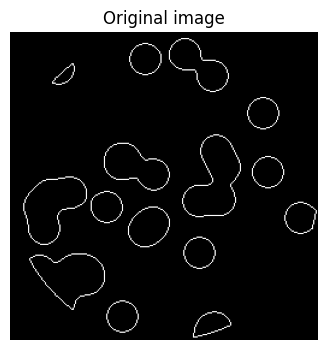

In [3]:
def generate_synthetic_data():
    """Synthetic binary data"""
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.0) ** 2 + (y - l / 2.0) ** 2 < (l / 2.0) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))


# Generate synthetic image
l = 256
img = generate_synthetic_data()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.imshow(img, cmap="gray")
ax.axis("off")
ax.set(title="Original image");

The image above consits only in the boundaries of a collection of objects, typical of cell material/boundaries in a biomedical sample.
This image is of size $l \times l$, where $l$ is the number of pixels in each direction.
Without any prior information about it, one would need of the order of $l$ or $l^2$ measurements to get a reasonable estimate.
In practice, radiographers however use a relatively small number of projections as each one of them amounts to shooting a beam of rays through a patient.
Here, only $l / 8$ projections are being used.
With $l = 256$, the image has $16 384$ pixels, but only 18 projections with angle between $0$ and $\pi$ are being used.
This leads to a total of $2304$ measurements, i.e. about one seventh of the total number of pixels in the image.

The tomography projection operation is a linear transformation and can thus be represent as a matrix $\mathbf{A}$. In addition to the measurements acquired, we add some random gaussian noise inherent in any real data.
The cell below constructs the tomography projection operator and provides the measurements we'll use hereafter.

In [4]:
def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.0
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x**2)
    data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator

# Generate synthetic images, and projections
A = build_projection_operator(l, l//16)
b = A @ img.flatten()
b += 0.15 * np.random.randn(*b.shape)

Before starting to use LASSO, let us consider a baseline model. Having fewer measurements than pixels that need estimating, the problem is thus underdetermined.
As a baseline model, we'll thus use a least-norm estimator.
The corresponding optimization problem reads

$$
\begin{aligned}
    \minimize_{\mathbf{x}} & \quad \dfrac12 \Vert \mathbf{x} \Vert_2^2 \\
    \subto & \quad \mathbf{Ax} = \mathbf{b}
\end{aligned}
$$

where $\mathbf{x}$ is the vector representation of the unknown image, $\mathbf{A}$ the tomography projection operator and $\mathbf{b}$ the measurements acquired.
The corresponding solution is

$$
\mathbf{x}_{\star} = \mathbf{A}^{\dagger} \mathbf{b},
$$

where $\mathbf{A}^{\dagger} = \mathbf{A}^T \left( \mathbf{AA}^T \right)^{-1}$ is the Moore-Penrose pseudo-inverse for a wide matrix.
This is computed below for you.

In [5]:
def least_norm(A, b):
    m, n = A.shape
    # Cholesky factorization.
    U, uplo = cho_factor((A @ A.T).todense() + 1e-8*np.eye(m))
    # Least-norm solution.
    x = A.T @ cho_solve((U, uplo), b)
    return x

x_lstnorm = least_norm(A, b)

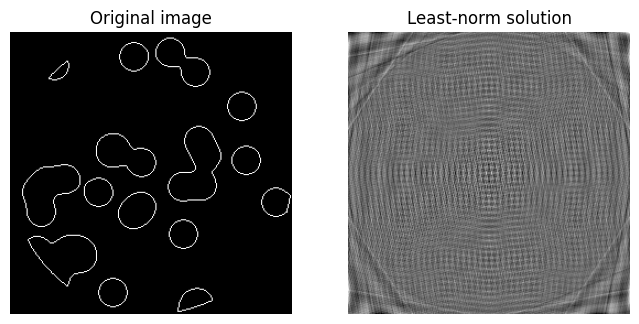

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

axes[0].imshow(img, cmap="gray")
axes[0].set(title="Original image")

axes[1].imshow(x_lstnorm.reshape(l, l), cmap="gray")
axes[1].set(title="Least-norm solution")

for ax in axes:
    ax.axis("off")

Clearly, the least-norm estimator leads to a terribly unsatisfactory reconstruction.
There are essentially two reasons for that:
1. The constraint $\mathbf{Ax} = \mathbf{b}$ needs to be satisfied exactly in the construction of the least-norm estimator eventhough we known that the measurement vector $\mathbf{b}$ is actually corrupted by noise.
2. Minimizing the 2-norm of the vector $\mathbf{x}$ is not the correct objective function to use as it does not lead to a sparse solution.

An alternative it thus to use a regularized least-squares estimator, the simplest one being [Ridge regression](https://en.wikipedia.org/wiki/Ridge_regression).
The corresponding optimization problem reads

$$
\begin{aligned}
    \minimize_{\mathbf{x}} & \quad \dfrac12 \Vert \mathbf{Ax} - \mathbf{b} \Vert_2^2 + \dfrac{\lambda}{2} \Vert \mathbf{x} \Vert_2^2.
\end{aligned}
$$

The minimizer of this problem is given by

$$
\mathbf{x}_{\star} = \left( \mathbf{A}^T \mathbf{A} + \lambda \mathbf{I} \right)^{-1} \mathbf{A}^T \mathbf{b}.
$$

Note that, up to the right-hand side vector, this problem is the same as the one being solved in the $\mathbf{x}$-minimization step of the ADMM solver.

In [7]:
def ridge_regression(A, b, λ):
    # Matrix dimension.
    m, n = A.shape
    # Cholesky factorization.
    U, uplo = factor(A, λ)
    # x-minimization.
    Atb = A.T @ b
    if m >= n: # Over-determined case.
        x = cho_solve((U, uplo), Atb, check_finite=False)
    else: # Under-determined case (use matrix inverse lemma).
        x = (Atb/λ) - A.T @ cho_solve((U, uplo), A @ Atb, check_finite=False) / λ**2
    return x

x_ridge = ridge_regression(A, b, 1.0)

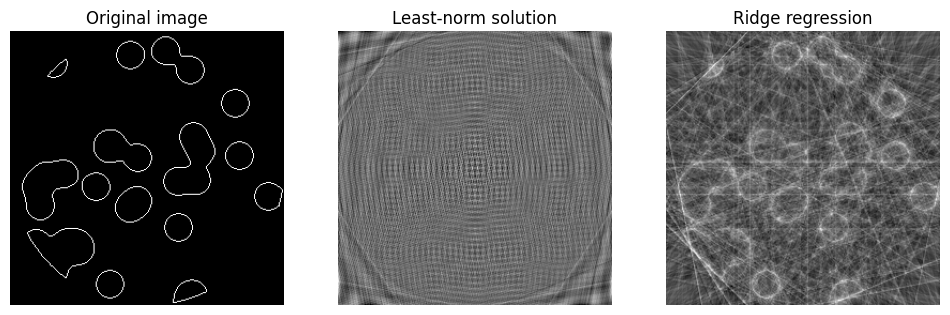

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

axes[0].imshow(img, cmap="gray")
axes[0].set(title="Original image")

axes[1].imshow(x_lstnorm.reshape(l, l), cmap="gray")
axes[1].set(title="Least-norm solution")

axes[2].imshow(x_ridge.reshape(l, l), cmap="gray")
axes[2].set(title="Ridge regression")

for ax in axes:
    ax.axis("off")

The image reconstructed using ridge regression is orders of magnitude better than the least-norm solution albeit not quite satisfactory yet.
Although we now recover the object, the image is polluted with numerous artifacts comming for the beam projections.
This comes once again from the fact the 2-norm does not promote the sparsity of the solution.

Let us finally look at the image obtained using the LASSO estimator based on the ADMM solver we've just implemented.

In [9]:
λ = 1.0  # Lasso hyper-parameter.
ρ = 10.0 # ADMM step size for the dual update.
x_lasso, *_ = lasso(A, b, λ, ρ)

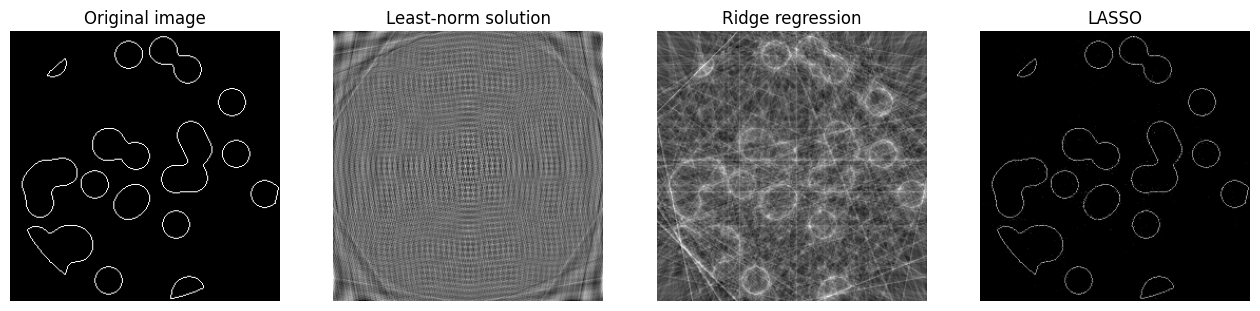

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)

axes[0].imshow(img, cmap="gray")
axes[0].set(title="Original image")

axes[1].imshow(x_lstnorm.reshape(l, l), cmap="gray")
axes[1].set(title="Least-norm solution")

axes[2].imshow(x_ridge.reshape(l, l), cmap="gray")
axes[2].set(title="Ridge regression")

axes[3].imshow(x_lasso.reshape(l, l), cmap="gray")
axes[3].set(title="LASSO")

for ax in axes:
    ax.axis("off")

Although the pixel intensities may be a bit off, it is clear that using the LASSO estimator leads to a correct recovery of the spatial support of the objects included in the image.
A lot more could be said about the conditions under which sparse sensing works (or not), but this is far beyond the scope of this notebook.

**Computational performances** - Before wrapping up, let us look at the computational performances of our solver.
Since the $x$-minimization in ADMM essentially amounts to solving a ridge regression problem, let us first time the ridge regression solver.
For that purpose, we will use the `%%timeit` magic command to run the solver multiple time and get some statistics about its execution time.

In [11]:
%timeit ridge_regression(A, b, λ)

The slowest run took 11.04 times longer than the fastest. This could mean that an intermediate result is being cached.
13.2 s ± 5.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


On my laptop, the ridge regression solver takes rougly 800 milliseconds to execute.
We can get a more fine-grained description of the solver by using a line profiler.
If you do not already have it, it is recommended to install the `line_profiler` python package.
This is done in the cell below for you if needed.

In [12]:
# Install line_profiler if needed.
!pip install line_profiler
# Import line_profiler into Jupyter.
%load_ext line_profiler

The utility `line_profiler` and the associated magic command `%lprun` enables you to time your code line by line.
Doing so allows us to see where the bulk of the computation is and identify possible bottlenecks.
The cell below runs the line profiler utility for the ridge regression solver.

In [13]:
%lprun -u 1.0 -f ridge_regression ridge_regression(A, b, λ)

Timer unit: 1 s

Total time: 15.2285 s
File: /tmp/ipykernel_8570/178311247.py
Function: ridge_regression at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def ridge_regression(A, b, λ):
     2                                               # Matrix dimension.
     3         1          0.0      0.0      0.0      m, n = A.shape
     4                                               # Cholesky factorization.
     5         1         15.2     15.2     99.6      U, uplo = factor(A, λ)
     6                                               # x-minimization.
     7         1          0.0      0.0      0.0      Atb = A.T @ b
     8         1          0.0      0.0      0.0      if m >= n: # Over-determined case.
     9                                                   x = cho_solve((U, uplo), Atb, check_finite=False)
    10                                               else: # Under-determined case (use matrix inverse lemma).
 

As you can see, more than 90% of the computational time is spent in computing the Cholesky factorization.
This is expected as this operation requires $\mathcal{O}(n^3)$ flops.
In contrast, solving the linear system once the Cholesky factorization has been computed is virtually free, accounting for less than 5% of the total computational time.
Since we have already leveraged the *identity + low-rank* structure of the matrix and the Woodbury-Sherman-Morrison matrix inversion lemma, there is not much we can do to further speed up the computation.
Ye, at the end of this notebook, we'll see how we can reformulate the problem to make of use of the sparse structure of $\mathbf{A}$ to further improve the performances.
This is however more advanced material combining convex optimization and numerical linear algebra.

Let us now look at the computational performances of our ADMM-Lasso solver.

In [14]:
%timeit lasso(A, b, λ, ρ)

The slowest run took 5.20 times longer than the fastest. This could mean that an intermediate result is being cached.
16.8 s ± 7.68 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


On my laptop, its execution takes roughly 5 seconds.
Although not reported here, it solved nearly 250 ridge regression process before it converged.
A naïve estimate would be that it'd take 250 times more time than needed to solve the original ridge regression, i.e. close to 3 minutes.
Yet, its computational time is only 7 times that of ridge regression.
How is this possible ?
To answer to this question, let us run the line profiler once more.

In [15]:
%lprun -u 1.0 -f lasso lasso(A, b, λ, ρ)

Timer unit: 1 s

Total time: 4.52062 s
File: /tmp/ipykernel_8570/325003199.py
Function: lasso at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                           def lasso(A, b, λ, ρ, maxiter=10_000, tol=1e-3):
    12                                               # Dimension of the problem.
    13         1          0.0      0.0      0.0      m, n = A.shape
    14                                               # Pre-allocations.
    15         1          0.0      0.0      0.0      x = np.zeros(n); u = np.zeros(n); z = np.zeros(n) # Solution vectors.
    16         1          0.0      0.0      0.1      Atb = A.T @ b                                     # Pre-allocate constant vector.
    17         1          0.6      0.6     13.8      U, uplo = factor(A, ρ)                            # Cholesky factorization.
    18                                           
    19                                               # Logging
    20      

Looking at this profile, we can see that most of time is spent on two operations:
- 20% of the time is spent in the computation of the Cholesky factorization which is done only once.
- 80% of the time is spent in solving the ridge regression problem, which is done roughly 250 times.

This illustrates the massive benefits one can gain by pre-computing and caching the Cholesky decomposition.
Doing so, its cost is amortized and the solver spends most of its time in doing actual useful non-redundant computations.
This is a recurrent theme in numerical linear algebra and there are many such tricks one can use to increase the computational performances.
The use of the Woodbury-Sherman-Morrison inversion lemma for the underdetermined case is another one of them.
It actually probably is the most important one !
Without it, our solver would be far from being competitive as it would require roughly an hour to converge !

**Even more performances !** - To finish, let us quickly some more advanced techniques enabling even more performances.
Not only is the tomography projection operator stored in a sparse format, but it actually is **very** sparse.

In [16]:
print("Only {0:0.2f}% of the entries of the matrix are non-zero.".format(100 * A.nnz / np.prod(A.shape)))

Only 0.74% of the entries of the matrix are non-zero.


Less than 1% of the entries of the matrix are actually non-zero.
Except for the matrix-vector product $\mathbf{A}^T \mathbf{b}$, nowhere is this sparsity pattern really leveraged here.
Yet, it is another key enabler of computational performances.
In particular, there exist algorithms that compute a sparse Cholesky factorization of matrices of the form $\rho \mathbf{I} + \mathbf{A}^T \mathbf{A}$.
In the rest of this notebook, we will rewrite the ADMM-LASSO solver using such functionalities.

<div class="alert alert-danger">
<b>WARNING</b> In order to execute the following cells, you need to have the python package <code>scikit-sparse</code> installed. This package can be installed via <code>pip</code>. Note however that it depends on the <code>suite-sparse</code> library. This library can be installed via <code>brew</code> (on MacOS) or <code>apt</code> on debian systems. For more information, please refer to the corresponding <a href="https://github.com/scikit-sparse/scikit-sparse">GitHub repo</a>.
</div>

In [17]:
from sksparse.cholmod import cholesky_AAt

def sparse_factor(A, ρ):
    m, n = A.shape
    if m >= n: # Over-determined case.
        F = cholesky_AAt(A.tocsr().T, beta=ρ)
    else: # Under-determined case (used for matrix inversion lemma).
        A = A/np.sqrt(ρ)
        F = cholesky_AAt(A.tocsc(), beta=1.0)
    return F
           
def sparse_lasso(A, b, λ, ρ, maxiter=10_000, tol=1e-3):
    # Dimension of the problem.
    m, n = A.shape
    # Pre-allocations.
    x = np.zeros(n); u = np.zeros(n); z = np.zeros(n) # Solution vectors.
    Atb = A.T @ b                                     # Pre-allocate constant vector.
    F = sparse_factor(A, ρ)                           # Cholesky factorization.
    
    # Logging
    logger = {"primal norm": [],
              "dual norm" : [],
              "primal residual" : [],
              "dual residual" : []}

    for i in range(maxiter):
        # x-update (Ridge-like regression).
        q = Atb + ρ*(z-u)
        if m >= n: # Over-determined case.
            x = F.solve_A(q)
        else: # Under-determined case (use matrix inverse lemma).
            x = (q/ρ) - A.T @ F.solve_A(A @ q) / ρ**2
        # z-update (Proximal operator).128
        z = shrinkage(x + u, λ/ρ)
        # y-update (Dual ascent).
        u += (x - z)

        # Various logging.
        logger["primal residual"].append(sp.linalg.norm(x-z, check_finite=False))
        logger["dual residual"].append(ρ*logger["primal residual"][-1]) # logger["dual residual"].append(sp.linalg.norm(ρ*(x-z)))
        logger["primal norm"].append(max(sp.linalg.norm(x, check_finite=False), sp.linalg.norm(z, check_finite=False)))
        logger["dual norm"].append(sp.linalg.norm(ρ*u, check_finite=False))
        
        if (logger["primal residual"][-1] < tol*logger["primal norm"][-1]) and (logger["dual residual"][-1] < tol*logger["dual norm"][-1]):
            break
            
    return z, logger

Before looking at the computational performances of this implementation, let us verify that it indeed computes the correct reconstructed image.

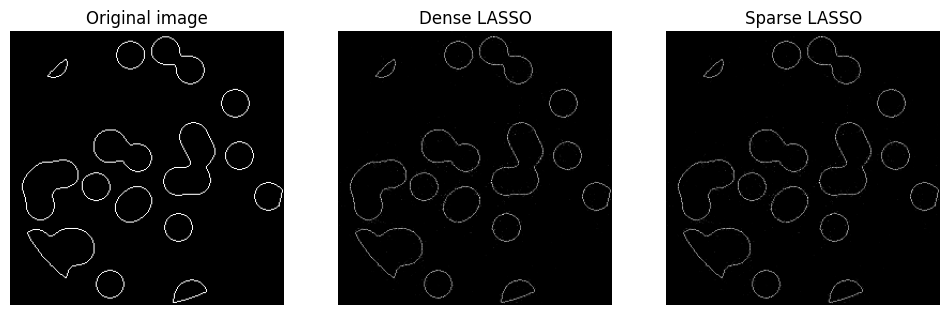

In [18]:
# Solve the tomography problem with the sparse-based LASSO solver.
x, logger = sparse_lasso(A, b, λ, ρ)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

axes[0].imshow(img, cmap="gray")
axes[0].set(title="Original image")

axes[1].imshow(x_lasso.reshape(l, l) / x_lasso.max(), cmap="gray")
axes[1].set(title="Dense LASSO")

axes[2].imshow(x.reshape(l, l), cmap="gray")
axes[2].set(title="Sparse LASSO")

for ax in axes:
    ax.axis("off")

As expected, the two solvers return the same solution to near machine-precision.
Let us now look at its computational performances.

In [19]:
%timeit sparse_lasso(A, b, λ, ρ)

3.07 s ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


While our original implementation took on average 5 seconds to solve the LASSO problem, this new one takes only 3.5 seconds.
For the present problem, leveraging the sparse Cholesky factorization enables us to improve the computational performances of our solver by nearly 30%!

In [20]:
%lprun -u 1.0 -f sparse_lasso sparse_lasso(A, b, λ, ρ)

Timer unit: 1 s

Total time: 3.18128 s
File: /tmp/ipykernel_8570/1736741053.py
Function: sparse_lasso at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                           def sparse_lasso(A, b, λ, ρ, maxiter=10_000, tol=1e-3):
    13                                               # Dimension of the problem.
    14         1          0.0      0.0      0.0      m, n = A.shape
    15                                               # Pre-allocations.
    16         1          0.0      0.0      0.0      x = np.zeros(n); u = np.zeros(n); z = np.zeros(n) # Solution vectors.
    17         1          0.0      0.0      0.1      Atb = A.T @ b                                     # Pre-allocate constant vector.
    18         1          0.4      0.4     13.9      F = sparse_factor(A, ρ)                           # Cholesky factorization.
    19                                           
    20                                               # Loggi

Looking at a more detailled profile of the code, we can see that, as before, the bulk of the computation is spent in computing the sparse Cholesky factorization (roughly 13% of the total time) and in the solution of 200-ish ridge regression problems (nearly 85% of the total time).
With all these optimizations, this solver for LASSO problems with sparse matrices $\mathbf{A}$ is probably as fast as it can get when one restrict themselves to direct linear algebra solvers.
Marginal performances might be gained by writting the solver in a more low-level language such as `Fortran` or `C`, albeit this would come at the cost of a possibly significant amount of development time.

This solver is able to compute the LASSO solution of a problem with 65 000 optimization variables in a few seconds. This is no small feast when you think about it.
Note however that, as the problem gets larger and larger, so is the cost (both computational and memory-wise) of computing the Cholesky factorization.
Eventually, the performances of this solver will degrade as $n$ gets too large (e.g. $n > 100\ 000$).
In such situations, direct linear algebra solvers can be replaced with iterative ones such as the [Conjugate Gradient Method](https://en.wikipedia.org/wiki/Conjugate_gradient_method).
While being theoretically efficient, these iterative solvers however often need to be preconditioned to achieve good performances.
Unfortunately, designing a good preconditioner is highly problem-dependent.
For such large-scale problems, other techniques need to be used such as subgradient methods.
Note however that, although not discussed in this notebook, one major benefit of the ADMM methodology is that it can easily be distributed and run in parallel.
This is however a story for another time.

### **Acknowledgements**

This work was made possible thanks to the financial support of the French National Agency for Research (ANR) through the ANR-33-CE46-0008-CONMAN grant agreement.

<img src="https://upload.wikimedia.org/wikipedia/fr/c/c3/Nouveau_logo_ANR_2022.jpg" style="width:256px" >